In [ ]:
%conda install pygmt # this needs to be conda to get all the required dependencies

In [1]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from skimage import exposure
from skimage.io import imsave, imread
from osgeo import ogr
import pystac_client
from pyproj import Transformer
from datetime import date, timedelta, datetime
import geopandas as gpd
import pandas as pd
import geoviews as gv
import hvplot.pandas
import intake
import xarray as xr
import numpy as np
from numpy.random import default_rng
import intake
import earthaccess
from pyproj import Proj, transform
from osgeo import gdal
from sklearn.neighbors import BallTree
import earthaccess

# for progress bar
from ipywidgets import IntProgress
from IPython.display import display
import time
from tqdm import tqdm

import boto3
import rasterio as rio
from rasterio.features import rasterize
from rasterio.session import AWSSession
import dask
import os
import rioxarray
from rasterio.enums import Resampling
from rasterio.warp import reproject
from rasterio.warp import Resampling as resample
import cartopy.crs as ccrs
import cartopy
from scipy.interpolate import BivariateSpline, UnivariateSpline
import scipy
import statsmodels.formula.api as smf
from shapely.geometry.polygon import Polygon
import pygmt
import gc
import pytz
import pyproj
from pathlib import Path

import warnings
warnings.filterwarnings('ignore')

/tmp/ipykernel_4096/2190967528.py:11: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd
/srv/conda/envs/notebook/lib/python3.10/site-packages/geoviews/operation/__init__.py:14: HoloviewsDeprecationWarning: 'ResamplingOperation' is deprecated and will be removed in version 1.18, use 'ResampleOperation2D' instead.
  from holoview

In [2]:
# Coefficients for calibration
calib_m = 0.79
calib_b = 0.73

### Functions

In [3]:
# Functions to search and open Lansat scenes
'''
Functions to search, open, and analyze Landsat scenes.
Search_stac finds the Landsat scene based on user parameters, 
plot_search plots the locations of the landsat scenes from the search,
landsat_to_xarray takes one of those scenes and puts all bands into an xarray,
and create_masks produces cloud/ice/water masks for the scene. Subset_img 
subsets a landsat scene with coordinates that have been reprojected from lat/lon
and may be flipped in which is larger in the pair. Lsat_reproj can be used to reproject
while ensuring x and y pairs don't get flipped (common converting between espg 3031 and wgs84.
'''

def landsat_to_xarray(sceneid, bandNames=None):
    """
    Function to ingest landsat scenes from AWS s3 bucket with alternate href.
    Args:
        catalog: an intake STAC item collection
        bandNames: a list of the bands you want e.g. ['red', 'swir16']
    Returns:
        Xarray of scenes with dimensions time, band, y, x
    """

    # Import to xarray with cloud mask
    # nans are in locations where concat of multiple scenes has expanded the grid
    item = catalog[sceneid.id]

    bands = []
    band_names = []

    if bandNames is None:
        # Get band names
        for k in item.keys():
            M = getattr(item, k).metadata
            if 'eo:bands' in M:
                resol = M['eo:bands'][0]['gsd']
                if resol >= 30: # thermal bands are up sampled from 100 to 30
                    band_names.append(k)
    else:
        band_names = bandNames

    # Add qa band
    if 'qa_pixel' not in band_names:
        band_names.append('qa_pixel')
    
    band_names.append('VZA')
    band_names.append('qa_radsat')

    # Construct xarray for scene
    for band_name in band_names:
        asset = sceneid.assets[band_name]
        href = asset.extra_fields['alternate']['s3']['href']

        band = xr.open_dataset(href, engine='rasterio', chunks=dict(band=1, x=512, y=512))
        band['band'] = [band_name]
        bands.append(band)
    ls_scene = xr.concat(bands, dim='band')
    ls_scene.coords['id'] = sceneid.id
    ls_scene.coords['time'] = item.metadata['datetime'].strftime('%Y-%m-%dT%H:%M:%S')
    ls_scene = ls_scene['band_data']

    return ls_scene

##########################

def create_masks(ls_scene, cloud_mask=True, ice_mask=False, ocean_mask=False):
    """
    Create cloud, ice, and ocean masks. cloud is 1, ice is 2, ocean is 3, everything else is NaN.
    Args:
        ls_scene: xarray of one LS scenes output from landsat_to_xarray
        cloud_mask: bool to generate cloud mask, default True
        ice_mask: bool to generate ice mask, default False
        ocean_mask: bool to generate ocean mask, default False
    Returns:
        new xarray of LS scene with mask
    """
    
    cloud = []
    ocean = []
    ice = []

    qa = ls_scene.sel(band='qa_pixel').astype('uint16')

    n,c = np.unique(qa, return_counts=True)

    for j in range(len(n)):
        longform = f'{n[j]:016b}'
        if (longform[-7]=='0')|(longform[-3]=='1'): #bit 2 and 6 are for cirrus and clear sky
            cloud.append(n[j])
        if longform[-8:]=='11000000': #bit 6 and 7 give clear sky and water, lower bits need to be 0 
            ocean.append(n[j])
        if longform[-7:]=='1100000': #bit 5 and 6 give ice and clear sky 
            ice.append(n[j])

    if 0 in cloud:
        cloud.remove(0)
    if 1 in cloud:
        cloud.remove(1)

    # mask cloud, ice, and ocean
    if cloud_mask==True:
        # cloud is 2
        mask_c = xr.where(qa.isin(cloud), 1, np.nan)

    if ice_mask==True:
        mask_c = xr.where(qa.isin(ice), 2, mask_c)

    if ocean_mask==True:
        mask_c = xr.where(qa.isin(ocean), 3, mask_c)

    ls_scene.coords['mask'] = (('y', 'x'), mask_c.data)
        
    return ls_scene

##########################

def normalize(array):
    '''
    normalize a dask array so all value are between 0 and 1
    '''
    array_min = array.min(skipna=True)
    array_max = array.max(skipna=True)
    return (array - array_min) / (array_max - array_min)

##########################

def search_stac(url,bbox,timeRange,collection,gjson_outfile):
    # Search STAC API for Landsat images based on a bounding box, date and other metadata if desired
    api = pystac_client.Client.open(url)

    items = api.search(
                bbox = bbox,
                datetime = timeRange,
                # limit = 400,
                collections=collection
            ).item_collection()

    print(f'{len(items)} items')

    # Write a json file that records our search output
    items.save_object(gjson_outfile)
    
    return items

##########################

def plot_search(gf,satellite,colnm):
    # Plot search AOI and frames on a map using Holoviz Libraries (more on these later)
    cols = gf.loc[:,('id',colnm[0],colnm[1],'geometry')]
    alpha = 1/gf.shape[0]**0.5 # transparency scales w number of images

    footprints = cols.hvplot(geo=True, line_color='k', hover_cols=[colnm[0],colnm[1]], alpha=alpha, title=satellite,tiles='ESRI')
    tiles = gv.tile_sources.CartoEco.options(width=700, height=500) 
    labels = gv.tile_sources.StamenLabels.options(level='annotation')
    tiles * footprints * labels
    
    return footprints

##########################

def subset_img(da,polarx,polary):
    '''
    Subset image in xarray to desired coordinates. Because Landsat polar stereo projection can be oriented
    in many different directions, when coordinates to subset an image are reprojected from lat/lon they may get 
    flipped for which is larger in the pair. This function checks to make sure we are getting a proper subset and 
    avoids 0 pixels on the x or y axis. 
    
    Note: Input shape dimensions and dataarray v. dataset changes things so input needs to be a dataarray w 
          2 dimensions (x,y)
    
    Input:
    da = xarray DataArray to be subset
    polarx = x coordinates to subset by in polar stereographic projection
    polary = y coordinates to subset by in polar stereographic projection
    
    Output:
    ls_sub = subset xarray DataArray
    
    '''
    # ***Landsat shape dimensions are one fewer than they are for LandsatCalibration [0,1] not [1,2], no .to_array() or Band
    ls_sub = da.sel(y=slice(polary[1],polary[0]),x=slice(polarx[0],polarx[1]))

    # Check for right dimensions because y order changes sometimes
    if (ls_sub.x.shape[0]==0) & (ls_sub.y.shape[0]==0):
        print ('L8 x and y shapes are 0')
        ls_sub = da.sel(y=slice(polary[0],polary[1]),x=slice(polarx[1],polarx[0]))
    elif ls_sub.y.shape[0]==0:
        print ('L8 y shape is 0')
        ls_sub = da.sel(y=slice(polary[0],polary[1]),x=slice(polarx[0],polarx[1]))
    elif ls_sub.x.shape[0]==0:
        print ('L8 x shape is 0')
        ls_sub = da.sel(y=slice(polary[1],polary[0]),x=slice(polarx[1],polarx[0]))
    print(ls_sub.shape)
    
    return ls_sub

##########################

def lsat_reproj(old_cs,new_cs,lbox):
    
    # Create a transform object to convert between Landsat coordinate systems (mostly for in and out of espg 3031)
    inProj = Proj(init=old_cs)
    outProj = Proj(init=new_cs)
    
    ULX,LRY,LRX,ULY = lbox

    if LRY>ULY:
        [ULX,LRX], [ULY,LRY] =  transform(inProj,outProj,[ULX,LRX], [ULY,LRY], always_xy=True)
    else:
        [ULX,LRX], [ULY,LRY] =  transform(inProj,outProj,[ULX,LRX], [LRY,ULY], always_xy=True)
    
    bbox = (ULX,LRY,LRX,ULY)
    
    return bbox

In [4]:
# Atmospheric correction and production of SST
'''
Functions to find the matching MODIS water vapor image for atmospheric correction and production of SST.
Open_MODIS finds and downloads the closest MODIS water vapor image to a specific landsat image. Get_wv
aligns and subsets the modis image grid to landsat using MODISlookup and subsamples and extracts the data 
onto the Landsat grid using uniqueMODIS
'''

def open_MODIS(ls_scene,scene,modout_path):
    '''
    Search MOD/MDY07 atmospheric data and open water vapor for data collected closest in time to 
    Landsat scene.
    
    Input:
    ls_scene = xarray dataset with Landsat scene
    modout_path = directory path for MODIS data
    scene = STAC catalog item
    
    Output:
    mod07 = xarray dataset with MODIS (MOD/MDY07) water vapor 
    modfilenm = MODIS filename for image used in atm correction
    '''
    
    # Get date/time for Landsat image and search for corresponding MODIS imagery  
    # ls_time = ls_scene.time.values.item()

    # Get spatial extent of Landsat scene
    mbbox = (scene.metadata['bbox'][0], scene.metadata['bbox'][1], scene.metadata['bbox'][2], scene.metadata['bbox'][3]) #(west, south, east, north) 
    lsatpoly = Polygon([(mbbox[0],mbbox[1]),(mbbox[0],mbbox[3]),(mbbox[2],mbbox[3]),(mbbox[2],mbbox[1]),(mbbox[0],mbbox[1])]) # ensure full lineup between landsat and modis
    
    # start_dt = ls_time[0:10]
    # calc_dt = datetime.strptime(start_dt, '%Y-%m-%d')
    # end_dt = (calc_dt + timedelta(days=1)).strftime('%Y-%m-%d')
    ls_time = pd.to_datetime(ls_scene.time.values)
    calc_dt = datetime.strptime(ls_time.strftime('%Y-%m-%d %H:%M:%S'), '%Y-%m-%d %H:%M:%S')
    start_dt = (calc_dt + timedelta(days=-0.5)).strftime('%Y-%m-%d %H:%M:%S')
    end_dt = (calc_dt + timedelta(days=0.5)).strftime('%Y-%m-%d %H:%M:%S')

    # Gather all files from search location from Terra and Aqua for the same day as the Landsat image
    results = earthaccess.search_data(
        short_name='MOD07_L2',
        bounding_box=mbbox,
        # Day of a landsat scene to day after - searches day of only
        temporal=(start_dt,end_dt)
    )
    results2 = earthaccess.search_data(
        short_name='MYD07_L2',
        bounding_box=mbbox,
        # Day of a landsat scene to day after - searches day of only
        temporal=(start_dt,end_dt)
    )
    results = results + results2
    print (f'{len(results)} TOTAL')

    # Accept only granules that overlap at least 90% with Landsat
    best_grans = []
    for granule in results:
        try:
            granule['umm']['SpatialExtent']['HorizontalSpatialDomain']['Geometry']['GPolygons']
        except Exception as error:
            print(error)
            continue
        for num in range(len(granule['umm']['SpatialExtent']['HorizontalSpatialDomain']['Geometry']['GPolygons'])):
            try:
                pgon = Polygon([(xi['Longitude'],xi['Latitude']) for xi in granule['umm']['SpatialExtent']['HorizontalSpatialDomain']['Geometry']['GPolygons'][num]['Boundary']['Points']])
                percent_dif = lsatpoly.difference(pgon).area/lsatpoly.area
                if percent_dif < 0.1:
                    best_grans.append(granule)
                    continue
            except Exception as error:
                print(error)
                # Would love to raise an exception for a valueerror except for GEOSError but not sure how 
    print(f'{len(best_grans)} TOTAL w overlap')
    
    # Find MODIS image closest in time to the Landsat image
    Mdates = [pd.to_datetime(granule['umm']['TemporalExtent']['RangeDateTime']['BeginningDateTime']) for granule in best_grans]
    ind = Mdates.index(min( Mdates, key=lambda x: abs(x - pytz.utc.localize(pd.to_datetime(ls_time)))))
    print(min( Mdates, key=lambda x: abs(x - pytz.utc.localize(pd.to_datetime(ls_time)))))

    # Download MODIS data if needed

    # # This doesn't work because xarray can't open legacy HDF EOS data formats
    # mod07 = xr.open_mfdataset(earthaccess.open(results))

    # Use these access pathways while S3 streaming is not working
    data_links = [granule.data_links(access="external") for granule in best_grans[ind:ind+1]]
    netcdf_list = [g._filter_related_links("USE SERVICE API")[0].replace(".html", ".nc4") for g in best_grans[ind:ind+1]]

    # This is going to be slow as we are asking Opendap to format HDF into NetCDF4 so we only processing 3 granules
    # and Opendap is very prone to failures due concurrent connections, not ideal.
    file_handlers = earthaccess.download(netcdf_list, modout_path,provider='NSIDC')


    # Open MODIS data
    mod_list = os.listdir(modout_path)
    mod_list = [file for file in mod_list if file[-3:]=='nc4']
    print(mod_list)
    modfilenm = mod_list[0]

    mod07 = xr.open_dataset(f'{modout_path}/{mod_list[0]}')
    mod07 = mod07.rio.write_crs('epsg:4326')

    # Delete MODIS file
    os.remove(f'{modout_path}/{mod_list[0]}')
    
    return mod07,modfilenm

##########################

def get_wv(ls_scene,mod07,spacing,param):
    '''
    ***This is copied in LandsatCalibration and changes there may generalize this!!
    
    Create water vapor files aligned and subsampled to Landsat
    
    Variables:
    ls_scene = xarray dataset of Landsat scene
    mod07 = xarray dataset with MODIS (MOD/MDY07) water vapor
    spacing = list of desired spatial resolution of data during alignment to MODIS in y and x (e.g.,[300,-300])
    param = string for desired dataset from MODIS file
    
    Output:
    WV_xr = xarray dataarray of Landsat aligned and upsampled dataset from MODIS
    
    '''
    # Read in desired variables and paths
    
    uniqWV = []

    ULX = ls_scene.x[0] 
    ULY = ls_scene.y[0]  
    LRX = ls_scene.x[-1] 
    LRY = ls_scene.y[-1] 
    box = [ULX,LRX,ULY,LRY]
              
    # Produce indicies for aligning MODIS pixel subset to match Landsat image at 4000m (or 300)resolution
    indiciesMOD,lines,samples,x1,y1 = MODISlookup(mod07,ls_scene,box,spacing)

    # Align MODIS WV to Landsat
    dataOutWV,uniqImgWV = uniqueMODIS(mod07,param,indiciesMOD,lines,samples) # dataOut = MODIS data aligned and subset to Lsat scene
    
    red_y = int(abs(spacing[0]/30))
    red_x = int(abs(spacing[1]/30))
    dataOutWV_xr = xr.DataArray(dataOutWV,name='SST',dims=["y","x"], coords={"latitude": (["y"],ls_scene.y.values[::red_y]), "longitude": (["x"],ls_scene.x.values[::red_x])})

    # dataOutWV_xr = xr.DataArray(dataOutWV,name='WV',dims=["y","x"], coords={"latitude": (["y"],ls_scene.y.values[::10]), "longitude": (["x"],ls_scene.x.values[::10])})

    # # Resample WV to Landsat resolution and interpolate with B-spline
    # # Need to use 0.1k (this samples at .1 of the grid)
    # # Output of shape fits and need to adjust x and y coords cuz are wrong
    ups_factor = 30/spacing[0]
    WV_upsample = pygmt.grdsample(grid=dataOutWV_xr, spacing=f'{ups_factor}k', interpolation='c')
    # WV_upsample = xr.open_dataarray(lsatpath+'WV_upsample_B-spline_'+str(ls_scene.id.values))
    # # Resample WV to Landsat resolution manual - no interpolation
    # WV_resamp = MODresample(ls_scene,dataOutWV,y1,x1,spacing)

    # Put into Xarray
    # Sometimes spacing works properly with -1 and sometimes not
    latnew = np.arange(dataOutWV_xr.latitude[0],dataOutWV_xr.latitude[-1]+1,(dataOutWV_xr.latitude[-1]-dataOutWV_xr.latitude[0])/(WV_upsample.shape[0]-1))
    if (WV_upsample.shape[0]!=latnew.shape[0]):
        latnew = np.arange(dataOutWV_xr.latitude[0],dataOutWV_xr.latitude[-1]+1,(dataOutWV_xr.latitude[-1]-dataOutWV_xr.latitude[0])/(WV_upsample.shape[0]))
    lonnew = np.arange(dataOutWV_xr.longitude[0],dataOutWV_xr.longitude[-1]+1,(dataOutWV_xr.longitude[-1]-dataOutWV_xr.longitude[0])/(WV_upsample.shape[1]-1))
    if (WV_upsample.shape[1]!=lonnew.shape[0]):
        lonnew = np.arange(dataOutWV_xr.longitude[0],dataOutWV_xr.longitude[-1]+1,(dataOutWV_xr.longitude[-1]-dataOutWV_xr.longitude[0])/(WV_upsample.shape[1]))
    WV_xr = xr.DataArray(WV_upsample,name='SST',dims=["y","x"], coords={"latitude": (["y"],latnew), "longitude": (["x"],lonnew)})
        
    # WV_xr = xr.DataArray(WV_upsample,name='WV',dims=["y","x"], coords={"latitude": (["y"],ls_scene.y.values), "longitude": (["x"],ls_scene.x.values)})
    WV_xr = WV_xr.rio.write_crs("epsg:3031", inplace=True)
    WV_xr = WV_xr.rename({'longitude':'x','latitude':'y'})

    #Append WV values
    uniqWV.append(uniqImgWV)
    
    return WV_xr
           
##########################           

def MODISlookup (mod07,lsat_filt_msk,box,spacing):
    '''
    Look up indices for aligning MODIS product to the Landsat grid
    # Modified from http://stackoverflow.com/questions/2922532/obtain-latitude-and-longitude-from-a-geotiff-file 
    # and Shane Grigsby

    Variables:    
    mod07 = xarray with MODIS data with crs 4326 assigned
    lsat_filt_msk =  Landsat xarray DataArray
    box = list with [left easting,right easting,top northing,bottom northing]
    spacing = desired pixel size for extraction, list of [east/west, north/south] 
          (recommend choosing a number that allows for fast calculations and even division by 30)

    Output:
    indiciesMOD = indicies used to project MODIS pixels to match Landsat pixels
    lines = number of lines in Landsat file/MODIS output shape
    samples = number of samples in Landsat file/MODIS output shape
    x1,y1 = x and y coordinates for grid
    '''
    
    lat, lon = mod07.Latitude, mod07.Longitude # Different for SST vs WV

    # Get the existing coordinate system
    old_cs = ls_scene.rio.crs #crs[6:] # 'epsg:3031'
    new_cs = mod07.rio.crs #'epsg:4326'

    # Create a transform object to convert between coordinate systems
    inProj = Proj(init=old_cs)
    outProj = Proj(init=new_cs)

    # Parse coordinates and spacing to different variables
    west,east,north,south = box
    ewspace,nsspace = spacing

    # Setting up grid, x coord from here to here at this spacing, mesh grid makes 2D
    samples = len(np.r_[west:east+1:ewspace])
    lines = len(np.r_[north:south-1:nsspace])#ns space is -300, could also do 30 instead of 300, but would just have duplicate pixels
    if lines==0:
        lines = len(np.r_[south:north-1:nsspace])
        
    # x1, y1 = np.meshgrid(np.r_[west:east:ewspace],np.r_[north:south:nsspace]) # offset by 1 meter to preserve shape
    ewdnsamp = int(spacing[0]/30)
    nsdnsamp = int(spacing[1]/30)
    x1, y1 = np.meshgrid(ls_scene.x.values[::ewdnsamp],ls_scene.y.values[::nsdnsamp])
    LScoords = np.vstack([x1.ravel(),y1.ravel()]).T

    # Ravel so ND can lookup easily
    # Convert from map coords to lat lon --> x = lon, y = lat
    xs, ys =  transform(inProj,outProj,LScoords[:,0], LScoords[:,1], radians=True, always_xy=True)
    grid_coords = np.vstack([ys.ravel(),xs.ravel()]).T # note y / x switch (i.e., lat long convention)
    
    if len(grid_coords) != lines*samples:
        raise Exception(f'Size of grid coordinates do not match low resolution Landsat dims: {len(grid_coords)} vs. {lines*samples}')
    MODIS_coords = np.vstack([lat.values.ravel(),lon.values.ravel()]).T
    MODIS_coords *= np.pi / 180. # to radians
    
    # Build lookup, haversine = calc dist between lat,lon pairs so can do nearest neighbor on sphere - if did utm it would be planar
    MOD_Ball = BallTree(MODIS_coords,metric='haversine') #sklearn library
    #LS_Ball = BallTree(grid_coords,metric='haversine') # In case want reverse coordinate for Landsat
    # Query modis coords with landsat coords, gives distance between and index for nearest neighbor
    distanceMOD, indiciesMOD= MOD_Ball.query(grid_coords, dualtree=True, breadth_first=True)
        
    return indiciesMOD,lines,samples,x1,y1

##########################

def uniqueMODIS(mod07,param,indiciesMOD,lines,samples):
    '''
    Extracts data values and unique values from desired MODIS dataset that corresponds to Landsat file
    # Modified from http://stackoverflow.com/questions/2922532/obtain-latitude-and-longitude-from-a-geotiff-file
    
    Variables: 
    mod07 = xarray with MOD07 data with crs 4326 assigned    
    param =  string for desired dataset from MODIS file
    indiciesMOD = indicies output for neighest neighbor query from MODIS to Landsat coordinates
    lines = number of lines in Landsat file/MODIS output shape
    samples = number of samples in Landsat file/MODIS output shape
    
    Output:
    dataOut = MODIS atm image subset and aligned to Landsat image pixels
    uniq = uniq MODIS atm values within area of Landsat image
    #counts = count for each unique value in subset
    '''
    # Convert from K to C
    KtoC = -273.15
    
    # Scaling coefficients for MODIS data
    wv_scale = 0.0010000000474974513
    ozone_scale = 0.10000000149011612
    
    #Extract desired datasets from MODIS file from lookup key
    data = mod07[param]
    lat, lon = mod07.Latitude, mod07.Longitude
    #data.attributes()

    if (np.shape(lat)== np.shape(lon)== np.shape(data))==False:
        raise Exception("Error in creating indicies, lat/lon and data shapes do not match")

    # Reproject data from MODIS into corresponding postions for Landsat pixels for water vapor and ozone
    if param == 'sst':
        dataOut = np.reshape(np.array(data.values.ravel())[indiciesMOD],(lines,samples))#* # to scale?
        dataOut[dataOut < -3] = np.nan
        MODimg = np.array(data.values)#* # to scale?
        MODimg[MODimg < 0] = np.nan
    elif param == 'Water_Vapor':
        dataOut = np.reshape(np.array(data.values.ravel())[indiciesMOD]*0.0010000000474974513,(lines,samples))
        dataOut[dataOut < 0] = np.nan
        MODimg = np.array(data.values*0.001000000047497451)
        MODimg[MODimg < 0] = np.nan
    elif param == 'Total_Ozone':
        dataOut = np.reshape(np.array(data.values.ravel())[indiciesMOD]*0.10000000149011612,(lines,samples))
        dataOut[dataOut < 225] = np.nan
        dataOut[dataOut > 430] = np.nan
        MODimg = np.array(data.values*0.10000000149011612)
        MODimg[MODimg < 0] = np.nan

    # Get unique values for datasets within Landsat extent
    #uniq, inverse, counts= np.unique(dataOut, return_inverse=True, return_counts=True)
    uniq = set(dataOut[np.isfinite(dataOut)])
    return dataOut,uniq # Can also output MODimg and inverse and counts if desired

## Derive NLSST coefficients for atmospheric correction

Non-linear SST (NLSST) atmospheric correction algorithm:

$$
  SST = a_0 + a_1\,T_L + a_2\,WV\,T_L
$$

where $a_k$ are derived coefficients, $T_L$ is TOA brightness temperature, and $WV$ is total column water vapor. We use this in `apply_NLSST`.

**Add TOA equations**

To calculate $WV$ ([https://resources.eumetrain.org/data/3/359/navmenu.php?tab=2&page=1.0.0](https://resources.eumetrain.org/data/3/359/navmenu.php?tab=2&page=1.0.0)) from ERA-5 specific humidities at atmospheric pressure levels along the total atmospheric column:

$$
  WV = \frac{1}{\rho_w\,g} \int_{p_z}^0 q(p)\,dp
$$

where $p_w$ is the water density 1000 $kg/m^3$; $g$ is the gravitational constant 9.8 $m/s^2$; $q(p)$ is the mixing ratio (g/kg) of water vapor in hPa at pressure level $p$, and $p_s$ is surface air pressure in hPa. That is calulated in `spec_hu_to_tcwv`. The mixing ratio $q(p)$ ([https://www.e-education.psu.edu/meteo300/node/519](https://www.e-education.psu.edu/meteo300/node/519)) is:

$$
  q(p) = \frac{q}{1-q}\,1000
$$

where $q$ is the specific humidity ($kg/kg$) at pressure level $p$. This is calculated in the `integ_mix_ratio` function in the `prep_NLSST` function below.

In [5]:
# Functions for deriving NLSST atmospheric correction coefficients
'''
These functions help to derive the NLSST atmospheric correction coefficients
prep_NLSST prepares the inputs for running the multiple regression that determines the coefficients, including
converting ERA-5 specific humidity data to total column water vapor in spec_hu_to_tcwv. Derive NLSST then takes
the inputs and runs an OLS multiple regression to derive the coefficients.
'''
def prep_NLSST(atmpath,prefix,spec_hu_file):
    '''
    Create the inputs for the NLSST algorithm using the atmospheric column inputs and outputs from 
    the MODTRAN model runs for Landsat. Uses specific humidity to calculate total column water vapor 
    for the NLSST multiple regression.
    
    Variable:
    atmpath = directory path where MODTRAN outputs are stored (str)
    prefix = beginning of file path name for MODTRAN outputs (str)
    spec_hu_file = file path for era5 input file for MODTRAN that includes specific humidity (str)
    
    Intermediates:
    modtran_lut = pandas dataframe of MODTRAN outputs
    modtran_atm = pandas dataframe of era5 atmopheric columns for input into MODTRAN
    
    Outputs:
    modtran_lut = pandas dataframe of MODTRAN outputs with total column water vapor [cm] added as 
                  a column
    '''
    
    # Open and concatenate MODTRAN outputs for SST algorithm
    # Get file paths
    modtr_list = os.listdir(atmpath)
    modtr_list = [file for file in modtr_list if file.startswith(prefix)]
    modtr_list.sort()

    # Open into pandas and concatenate
    df_list = []
    lut_cols = ['wind spd [m/s]','Surface T[K]','TOA T[K]','transmittance','jakobian']
        
    for mfile in modtr_list:
        df_list.append(pd.read_csv(f'{atmpath}/{mfile}', sep=' ',header=None,names=lut_cols))

    modtran_lut = pd.concat(df_list, ignore_index=True)
    modtran_lut['TCWV [cm]'] = np.nan
    
    
    # Open atm profiles for input of water vapor specific humidity
    atm_cols = ['Altitude [km]', 'pressure [hPa]', 'temp [K]', 'spec humidity [kg/kg]']
    modtran_atm = pd.read_csv(f'{atmpath}/{spec_hu_file}', sep='\t',header=None,names=atm_cols)
    
    
    # Calculate total column water vapor for each atm column using specific humidity from era5 inputs ***currently slow (~30min)
    # Function to calculate water vapor mixing ratio
    integ_mix_ratio = lambda x, df: ((df[df['pressure [hPa]']==x]['spec humidity [kg/kg]'] / (1-df[df['pressure [hPa]']==x]['spec humidity [kg/kg]']))*1000).values[0]
    
    # Run integral to get tcwv
    modtran_lut = spec_hu_to_tcwv(modtran_lut,modtran_atm,integ_mix_ratio)
    
    print (modtran_lut['TCWV [cm]'].max())
    print (modtran_lut['TCWV [cm]'].min())
    
    return modtran_lut

##########################

def derive_NLSST(modtran_lut):
    '''
    Derive the NLSST coefficients from the atmospheric column inputs and outputs to the MODTRAN
    model runs for Landsat using multiple regression. 
    
    Variables:
    modtran_lut = pandas dataframe that includes columns for surface temperature [K], top of 
                  atmosphere brightness temperature [K], total column water vapor [cm]
    
    Outputs:
    results = multiple regression summary and derived coefficients (ak) for NLSST atmospheric correction
    '''
    # Run OLS multiple regression to derive atmospheric correction coefficients
    df_newnames = modtran_lut.rename(columns={'Surface T[K]': 'surface', 'TOA T[K]': 'toa', 'TCWV [cm]': 'tcwv'})
    df_newnames['tcwv_toa'] = df_newnames['tcwv']*df_newnames['toa']
    results = smf.ols('surface ~ toa + tcwv_toa', data=df_newnames).fit()
 
    return results

##########################

def spec_hu_to_tcwv(modtran_lut,modtran_atm,integ_mix_ratio,atm_levels=37):
    '''
    Calculate total column water vapor by integrating across all atmospheric pressure levels 
    (modtran_atm) for each atmospheric column (modtran_lut) using non-uniform grid trapezoidal 
    integration method F(xp-1) + F(xp) / 2 * dp
    
    m & r track the individual atmospheric columns (dc)
    
    Variables:
    modtran_lut = pandas dataframe of MODTRAN outputs
    modtran_atm = pandas dataframe of era5 atmopheric columns for input into MODTRAN
    integ_mix_ratio = function for calculating the mixing ratio (g/kg) from specific humidity (kg/kg)
    atm_levels = number of atmospheric level in modtran_atm (default=37) (int)
    
    Output:
    modtran_lut = original dataframe with column added for total column water vapor 
    '''

    m = 0
    for y in tqdm(range(modtran_lut.shape[0]-1)):
        r = m + atm_levels
        df = modtran_atm.iloc[m:r]
        wvmr = [integ_mix_ratio(1,df)/2] # for p = 1, see eq. below, but fx_0 is 0 and dp is 1

        # convert from kg/kg to g/kg
        for i in range(1,df['pressure [hPa]'].size):
            p_0 = df['pressure [hPa]'].iloc[i-1]
            p = df['pressure [hPa]'].iloc[i]
            fx_0 = integ_mix_ratio(p_0,df)
            fx = integ_mix_ratio(p,df)
            wvmr.append(((fx_0 + fx/2)*(p-p_0)))

        # convert back to kg/m2 which is equivalent to mm, then convert to cm to match modis
        modtran_lut['TCWV [cm]'].iloc[y] = ((1/1000*9.8) * sum(wvmr) / 1000 / 10) 
        m = r
    
    return modtran_lut

In [6]:
# Functions to produce SST with atmospheric correction
'''
Functions to produce SST with atmospheric correction
apply_NLSST preps the masks and thermal data then runs the entire NLSST correction and calibration pipeline in lsatAtmCorr,
lsatAtmCorr calculates top of atmosphere brightness temperatures from thermal digital numbers data in TOA_BT and applies 
the atmospheric correction to get absolute temperatures [C] using NLSST.
'''

##########################

def TOA_BT(ls_thermal,scene):
    '''
    Calculate TOA radiance and brightness temperature using MTL json
    
    ls_thermal = xarray dataset of Landsat thermal data computed
    scene = catalog item for landsat scene
    
    Using equations from https://www.usgs.gov/landsat-missions/using-usgs-landsat-level-1-data-product
    '''
    
    # Calculate radiances using MTL data
    s3 = boto3.client("s3")

    # Extract bucket and key for json MTL file
    # Example: bucket = "usgs-landsat" ; key = "collection02/level-1/standard/oli-tirs/2019/002/113/LC08_L1GT_002113_20190206_20201016_02_T2/LC08_L1GT_002113_20190206_20201016_02_T2_MTL.json"
    s3_url = scene['MTL.json'].metadata['alternate']['s3']['href']
    bucket = s3_url.split('/')[2].strip()
    key = s3_url.split(bucket)[1].strip()[1:]

    # Get MLT data
    res = s3.get_object(Bucket=bucket, Key=key, RequestPayer="requester")
    MTL = res["Body"].read().decode("utf-8")

    # Get important constants from MTL
    ind = MTL.find('K1_CONSTANT_BAND_10')
    K1_10 = float(MTL[ind+23:ind+31])
    ind = MTL.find('K2_CONSTANT_BAND_10')
    K2_10 = float(MTL[ind+23:ind+32])
    ind = MTL.find('RADIANCE_MULT_BAND_10')
    ML10 = float(MTL[ind+25:ind+35])
    ind = MTL.find('RADIANCE_ADD_BAND_10')
    AL10 = float(MTL[ind+24:ind+31])

    # Get band 10
    # DN = ls_scene.sel(band='lwir11')
    # DN = DN.compute()

    # Mask no data
    # DN_masked = DN.where(DN != 0)  
    DN_masked = ls_thermal.where(ls_thermal != 0)

    # Top of Atmosphere radiance for Band 10
    Llambda = ML10 * DN_masked + AL10

    # Top of Atmosphere brightness temperature for Band 10
    T10 = K2_10 / np.log((K1_10 / Llambda) + 1)
    return T10

##########################
                    
def NLSST(toa,wv,a0,a1,a2):
    '''
    Calculates the surface temperature 
    
    Variables:
    toa = calculated TOA [K]
    wv = total column water vapor
    ak = derived NLSST coefficients
    
    Output:
    SST = sea surface temperature [C]
    '''
    
    SST = a0 + a1*toa + a2*wv*toa - 273.15
    return SST

##########################

def lsatAtmCorr(ls_thermal,scene,mask,modwv,a0,a1,a2):
    '''
    Applies atmospheric correction to top of atmosphere (TOA) brightness temperatures and converts to 
    absolute temperature for Landsat thermal images. Uses a derived coefficients for a non-linear
    sea surface temperature algorithm (NLSST) and water vapor from MODIS to produce the atmospheric 
    correction.

    Variables:
    ls_thermal = xarray dataset of Landsat thermal band computed 
    scene = STAC catalog item for the Landsat scene
    modwv = Water Vapor array (or other varrying parameter) from MODIS that has been 
            processed to the same dimensionality and pixel size as the Landsat image
    ak = derived NLSST coefficients 

    Previously defined:
    ak = derived NLSST coefficients

    Output: SST 2D array and GTiff of atmospheric corrected absolute temperatures [C]

    '''
    
    T10 = TOA_BT(ls_thermal,scene)
    T10 = mask * T10
    SST = NLSST(T10,modwv,a0,a1,a2)
    SST = SST.compute()
        
    return SST

##########################

def apply_NLSST(ls_thermal,scene,mask,WV_xr,a0,a1,a2):
    '''
    Use MODIS water vapor and landsat DN in NLSST algorithm to derive sea surface temperature.
    
    Variables:
    ls_scene = xarray dataset of Landsat scene  
    scene = STAC catalog item for the Landsat scene
    WV_xr = xarray dataarray of MODIS water vapor values matching timing of the landsat scene  
    ak = derived NLSST coefficients 
    
    Outputs:
    SST = multiple regression summary and derived coefficients (ak) for NLSST atmospheric correction
    Also saves a cloud-optimized geotiff of SST
    '''
    try:
        wv2 = mask*WV_xr.values

        # Get rid of low outliers from over ice, cutoff for 98.5%
        outlier = np.quantile(wv2[np.isfinite(wv2)],0.015)
        mask2 = np.ones(wv2.shape)
        mask2[wv2<outlier] = np.nan

        wv3 = mask2*wv2
        wv3 = mask*np.around(wv3,decimals=5)

        means = np.nanmean(wv3)
        print (f'Mean water vapor value is: {means}, min: {np.nanmin(wv3)}, max: {np.nanmax(wv3)}')

        # Apply atmospheric correction to get absolute temps in C
        SST = lsatAtmCorr(ls_thermal,scene,mask,wv3,a0,a1,a2)
        
        return SST
        
    except Exception as e: 
        print(e)
        print (f'atm correction of {ls_scene.id.values} failed')

# Run NLSST algorithm

In [7]:
timing = time.time()

In [8]:
# Define the landsat STAC catalog location
url = 'https://landsatlook.usgs.gov/stac-server'

# For atm correction
basepath = Path('/home/jovyan/Landsat_SST_algorithm')
lsatpath = basepath / 'Data'
atmpath = lsatpath / 'AtmCorrection'
modout_path = lsatpath / 'MOD07_L2'
NLSST_input_file = atmpath / 'TCWV_20230606'
spec_hu_file = 'modtran_atmprofiles_01_20230328.txt'
SSTpath = lsatpath / 'SST/UncalibratedSST/PineIslandPlume/'
WV = 'Water_Vapor'
prefix = 'antarctic'

# For search and tile plot for Landsat
satellite = 'Landsat8'
collection = 'landsat-c2l1' # Landsat Collection 2, Level 1 - includes L8 and L9
colnm = ['landsat:wrs_path','landsat:wrs_row']
gjson_outfile = lsatpath / f'{satellite}.geojson'

# For scene search and plot
# bbox = (-99.2,-69.9,-98.4, -69.6) # Offshelf BAD
# bbox = (-103.0, -73.5, -102.0, -73.42) # LatboundsC from LandsatCalibration20201031
# bbox = (-113, -73.9, -111.5, -73.5) # Dotson polynya
# bbox = (-101.88,-75.23,-100.35,-74.76) # PIG ice front for analysis
bbox = (-101.98,-75.09,-101.65,-75.05) # PIG plume for analysis - 2014
# bbox = (-113.5,-74.20,-113.17,-74.11) # Dotson plume for analysis 

In [22]:
# Authenticate for accessing all data # This cell disappears if I make it markdown

In [23]:
# Authenticate for boto S3 access, etc.
os.environ["AWS_REQUEST_PAYER"] = "requester"
aws_session = AWSSession(boto3.Session(), requester_pays=True)

In [11]:
# Setup and authenticate 
from dask.distributed import Client
import logging
client = Client(processes=True, n_workers=4, 
                threads_per_worker=1,
                silence_logs=logging.ERROR)
client.run(lambda: os.environ["AWS_REQUEST_PAYER"] == "requester" )
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/tsnow03/proxy/8787/status,
Dashboard: /user/tsnow03/proxy/8787/status,Workers: 4
Total threads: 4,Total memory: 20.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:44989,Workers: 4
Dashboard: /user/tsnow03/proxy/8787/status,Total threads: 4
Started: Just now,Total memory: 20.00 GiB
Comm: tcp://127.0.0.1:45415,Total threads: 1
Dashboard: /user/tsnow03/proxy/36947/status,Memory: 5.00 GiB
Nanny: tcp://127.0.0.1:37573,


In [12]:
# Authenticate for accessing NASA data (MODIS)
auth = earthaccess.login(strategy="netrc")
# are we authenticated?
if not auth.authenticated:
    # ask for credentials and persist them in a .netrc file
    auth.login(strategy="interactive", persist=True)

You're now authenticated with NASA Earthdata Login
Using token with expiration date: 09/16/2023
Using .netrc file for EDL


In [13]:
# Derive NLSST coefficiencts from MODTRAN files
if os.path.isfile(NLSST_input_file):
    print ('NLSST input exists')
    modtran_lut = pd.read_pickle(NLSST_input_file)

else:
    modtran_lut = prep_NLSST(lsatpath,prefix,spec_hu_file)
    modtran_lut.to_pickle(NLSST_input_file)
    

NLSST_results = derive_NLSST(modtran_lut)
a0 = NLSST_results.params.Intercept
a1 = NLSST_results.params.toa
a2 = NLSST_results.params.tcwv_toa

print(NLSST_results.summary())

NLSST input exists
                            OLS Regression Results                            
Dep. Variable:                surface   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                 3.611e+06
Date:                Wed, 23 Aug 2023   Prob (F-statistic):               0.00
Time:                        18:02:41   Log-Likelihood:                 30130.
No. Observations:               24551   AIC:                        -6.025e+04
Df Residuals:                   24548   BIC:                        -6.023e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -7.1774      0.126 

In [14]:
# Plot multiple linear regression in 3D
# fig, ax = plt.subplots(nrows=1, ncols=1, sharey=True,figsize=(6, 4))
# xi = np.arange(-7.0,5.0,1.0)

# data = lsat_mod_df_n

# a1 = ax
# a1.tick_params(labelsize=14)
# a1.scatter(data[xdata],data[ydata],color='k',linewidth=0,s=35,label='_no label_')
# # a1.plot(xi,xi*lreg.coef_[0]+lreg.intercept_[0],color='r',linewidth=2,label='RANSAC regression')
# a1.plot(xi,xi*resultC.params.MODIS_SST+resultC.params.Intercept,color='k',linewidth=2,label='OLS regression')
# a1.text(-2.1,-2.85,'y=0.73x-0.95   p=0.001',fontsize=14)
# a1.spines['top'].set_visible(False)
# a1.spines['right'].set_visible(False)
# a1.set_ylim([-3,2.5])
# a1.set_xlim([-3,2.5])
# a1.set_xlabel('MODIS SST [C]',fontsize=16)
# a1.set_ylabel('Landsat SST [C]',fontsize=16)
# a1.legend(markerscale=1,fontsize=14,loc='upper left')

# plt.tight_layout()
# # plt.savefig('/Users/tsnow03/GoogleDrive/User/Docs/PhD_Project/Manuscripts/AmundsenCC_Manuscript/Figures/LMCalibration.jpg', format='jpg', dpi=1000)
# plt.show()

In [15]:
# # Info on MODIS atmospheric dataset (MOD/MYD07 Level 2)
# from pprint import pprint
# datasets = earthaccess.search_datasets(short_name="MOD07_L2",
#                                        cloud_hosted=True)

# for dataset in datasets:
#     pprint(dataset.summary())

## Search for desired Landsat scenes

In [16]:
# # Test values, keep scene [3]
# bbox = (-106.5, -75.0, -104.9, -74.7) #(west, south, east, north) 
# timeRange = '2019-02-06/2019-02-07'

timeRange = '2020-08-01/2021-04-30'

In [17]:
# Search for desired Landsat scenes
items = search_stac(url,bbox,timeRange,collection,gjson_outfile)

# Open stac catalog for some needed info
catalog = intake.open_stac_item_collection(items)

# Load the geojson file
gf = gpd.read_file(gjson_outfile)

104 items


In [18]:
# Plot tiles of all scenes found
plot_search(gf,satellite,colnm)

:Overlay
   .Tiles.I    :Tiles   [x,y]
   .Polygons.I :Polygons   [Longitude,Latitude]   (landsat:wrs_path,landsat:wrs_row)

**Note the bands you would like to include are assigned by passing the bandNames parameter to landsat_to_xarray using the following codes:**

'coastal', 'blue', 'green', 'red', 'nir08', 'swir16', 'swir22', 'pan', 'cirrus', 'lwir11', 'lwir12', 'qa_pixel'

## Process Landsat scenes to acquire sea surface temperature

In [19]:
# Convert bounding box to polar for checking if landsat has any data in bounding box
# Speeds up process a lot
source_crs = 'epsg:4326' 
target_crs = 'epsg:3031' # Coordinate system of the file

topolar = pyproj.Transformer.from_crs(source_crs,target_crs)
polarx,polary = topolar.transform([bbox[3],bbox[1]],[bbox[0],bbox[2]]) #LRX,LRY with ULX,ULY

In [20]:
# %%time  
## At 1 min 5 sec per image
# Saves MODIS water vapor file name in COG so know what each image was corrected with

# Include only Landsat 8 scenes
catalog_list = [x for x in items if x.id[3]=='8']

for sceneid in catalog_list:
    print(sceneid.id)
    
    scene = catalog[sceneid.id]
    timestr = scene.metadata['datetime'].strftime('%H%M%S')

    outFile = f'{SSTpath}/{sceneid.id}_{timestr}_Cel.tif'
    
    if os.path.isfile(outFile):
        print (f'{sceneid.id} - atm corr exists')

    else:
        # Open all desired bands for one scene
        ls_scene = landsat_to_xarray(sceneid)
        ls_scene = ls_scene.rio.write_crs("epsg:3031", inplace=True)

        # Create classification mask
        ls_scene = create_masks(ls_scene, cloud_mask=True, ice_mask=True, ocean_mask=True)
        
        try:
            # Check for any open ocean pixels in bounding box - go to next image if none - 9.3 s
            mask = np.ones(ls_scene.shape[1:])
            mask[ls_scene.mask!=3] = np.nan
            ls_thermal = ls_scene.sel(band='lwir11').compute()
            ls_box = subset_img(ls_thermal*mask,polarx,polary)
            # ls_box = (ls_thermal*mask).sel(y=slice(polary[1],polary[0]),x=slice(polarx[0],polarx[1]))

            if ((ls_box).notnull()).sum().values==0:
                print (f'{sceneid.id} has no SSTs')
                try:
                    del ls_scene, scene, mask, ls_thermal, ls_box
                except:
                    pass
                gc.collect()
                continue

            # Use band ratios for RF cloud pixel classification
            ####

            # Atmospheric correction using MODIS
            # Acquire and align MODIS water vapor (MOD/MYD07) to Landsat
            mod07,modfilenm = open_MODIS(ls_scene,scene,modout_path)

            # Create water vapor files aligned and subsampled to Landsat
            spacing = [300,-300] # 300m sampling of MODIS data so that upsampling is easy and because 30m takes far too long
            WV_xr = get_wv(ls_scene,mod07,spacing,WV)

            # Create SST by masking and using water vapor to apply atmospheric correction
            SST = apply_NLSST(ls_thermal,scene,mask,WV_xr,a0,a1,a2)
            
            # Record MODIS water vapor image used in atmospheric correction, will find this info save under band_data in
            # data variables in COG (click on white paper info button in xarray readout)
            SST.attrs['MODIS_WV'] = modfilenm

            print (f'Mean SST: {np.nanmean(SST)}')

            # Save to a cloud-optimized Geotiff
            SST.rio.to_raster(raster_path=outFile, driver="COG")
            
        except Exception as e:
            print (f'{sceneid.id} has no SSTs: {e}')
        
        try:
            del ls_scene, scene, ls_thermal, ls_box, mod07, WV_xr, SST
        except:
            pass
        
        gc.collect()

LC08_L1GT_232113_20210326_20210401_02_T2
(337, 80)
LC08_L1GT_232113_20210326_20210401_02_T2 has no SSTs
LC08_L1GT_001113_20210324_20210401_02_T2
(337, 80)
LC08_L1GT_001113_20210324_20210401_02_T2 has no SSTs
LC08_L1GT_003113_20210322_20210401_02_T2
(337, 80)
LC08_L1GT_003113_20210322_20210401_02_T2 has no SSTs
LC08_L1GT_231114_20210319_20210328_02_T2
(337, 80)
LC08_L1GT_231114_20210319_20210328_02_T2 has no SSTs
LC08_L1GT_233114_20210317_20210328_02_T2
(337, 80)
LC08_L1GT_233114_20210317_20210328_02_T2 has no SSTs
LC08_L1GT_233113_20210317_20210328_02_T2


2023-08-23 18:06:07,399 - distributed.nanny - ERROR - Worker process died unexpectedly
Process Dask Worker process (from Nanny):
Process Dask Worker process (from Nanny):
Process Dask Worker process (from Nanny):
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.10/site-packages/distributed/nanny.py", line 981, in _run
    asyncio.run(run())
  File "/srv/conda/envs/notebook/lib/python3.10/asyncio/runners.py", line 44, in run
    return loop.run_until_complete(main)
  File "/srv/conda/envs/notebook/lib/python3.10/asyncio/base_events.py", line 636, in run_until_complete
    self.run_forever()
  File "/srv/conda/envs/notebook/lib/python3.10/asyncio/base_events.py", line 603, in run_forever
    self._run_once()
  File "/srv/conda/envs/notebook/lib/python3.10/asyncio/base_events.py", line 1871, in _run_once
    event_list = self._selector.select(timeout)
  File "/srv/conda/envs/notebook/lib/python3.10/selectors.py", line 469, in select
    fd_event_list = self.

In [ ]:
# # To make a list of images with SST in a desired box
# catalog = intake.open_stac_item_collection(items)

# # Include only Landsat 8 scenes
# catalog_list = [x for x in list(catalog) if x[3]=='8']

# if calib==1:
#     print('Running calibration!')
    
# mm=0
# lsat_good = []

# for img in catalog_list[847:1047]:
#     print(img)
    
#     scene = catalog[img]
#     timestr = scene.metadata['datetime'].strftime('%H%M%S')

#     if calib==1:
#         outFile = f'{lsatpath}{SSTpath}/{img}_{timestr}_Cel_calib.tif'
#     elif calib==0:
#         outFile = f'{lsatpath}{SSTpath}/{img}_{timestr}_Cel.tif'
    
#     if os.path.isfile(outFile):
#         print (f'{img} - atm corr exists')

#     else:
#         print(mm)
#         mm+=1
#         # Open all desired bands for one scene
#         ls_scene = landsat_to_xarray(scene)
#         ls_scene = ls_scene.rio.write_crs("epsg:3031", inplace=True)

#         # Create classification mask
#         ls_scene = create_masks(ls_scene, cloud_mask=True, ice_mask=True, ocean_mask=True)
        
#         try:
#             # Check for any open ocean pixels - go to next image if none - 9.3 s
#             mask = np.ones(ls_scene.shape[1:])
#             mask[ls_scene.mask!=3] = np.nan
#             ls_thermal = ls_scene.sel(band='lwir11').compute()
#             # Check in bounding box or for entire Landsat image depending on whether doing calibration runs or not
#             if calib==0:
#                 ls_box = (ls_thermal*mask).sel(y=slice(polary[1],polary[0]),x=slice(polarx[0],polarx[1]))
#             else:
#                 ls_box = ls_thermal
                
#             if ((ls_box).notnull()).sum().values==0:
#                 print (f'{img} has no SSTs')
#                 del ls_scene, scene, mask, ls_box
#                 gc.collect()

#             else:
#                 lsat_good.append([img,((ls_box).notnull()).sum().values])
#                 del ls_scene, scene, mask, ls_box, ls_thermal

#         except Exception as e:
#             print (f'{img} has no SSTs: {e}')
        
#         gc.collect()

In [8]:
# # Save list and re-open list
# import pickle
# with open(lsatpath+'landsat8_goodfiles_dotson_2021_2023', "wb") as fp:   #Pickling
#     pickle.dump(lsat_good, fp)

# with open(lsatpath+'landsat8_goodfiles_dotson_1', "rb") as fp:   # Unpickling
#     bb = pickle.load(fp)
# len(bb)

# import csv

# with open(lsatpath+'landsat8_goodfiles_dotson_forTed.csv', 'w', newline = '') as csvfile:
#     my_writer = csv.writer(csvfile, delimiter = ' ')
#     my_writer.writerow(bb)

In [33]:
# # Plot water vapor data ***need to comment out the delete code above for this to work
# plt.figure(figsize=(6, 3))
# ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_global()
# cb = ax.pcolormesh(WV_xr.x,WV_xr.y,WV_xr,transform=cartopy.crs.epsg(3031))
# ax.coastlines()
# ax.set_ylim([-76, -69])
# ax.set_xlim([-115,-95])
# cbar = plt.colorbar(cb)
# plt.tight_layout()

In [ ]:
# # Plot SST data ***need to comment out the delete code above for this to work
# plt.figure(figsize=(6, 3))
# ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_global()
# cb = ax.pcolormesh(WV_xr.x,WV_xr.y,SST,transform=cartopy.crs.epsg(3031))
# ax.coastlines()
# ax.set_ylim([-74.4, -74.2])
# ax.set_xlim([-103.9,-103.5])
# cbar = plt.colorbar(cb)
# # cbar.set_clim(-1, -6) # set limits of color map
# plt.tight_layout()

### Mosaic SST images from Xarray
https://github.com/pangeo-data/cog-best-practices/issues/4

# Validate via GHRSST iQUAM data
https://www.star.nesdis.noaa.gov/socd/sst/iquam/?tab=0&dateinput_year=2023&dateinput_month=02&dayofmoninput_day=26&dateinput_hour=00&dayofmon=monthly&qcrefsst=_qcrey&qcrefsst=_qccmc&outlier=qced#qmap

In [33]:
# Landsat STAC catalog location
url = 'https://landsatlook.usgs.gov/stac-server'

# Paths
basepath = Path('/home/jovyan/Landsat_SST_algorithm')
lsatpath = basepath / 'Data'
atmpath = lsatpath / 'AtmCorrection'
modout_path = lsatpath / 'MOD07_L2'
SSTpath = lsatpath / 'SST/Validation/iQuamIntercomp/'
NLSST_input_file = atmpath / 'TCWV_20230606'
spec_hu_file = 'modtran_atmprofiles_01_20230328.txt'

# For atm correction
WV = 'Water_Vapor'

# For geopandas and tile plots
satellite = 'Landsat8'
collection = 'landsat-c2l1' # Landsat Collection 2, Level 1
colnm = ['landsat:wrs_path','landsat:wrs_row']
gjson_outfile = lsatpath / f'{satellite}_iQuam.geojson'

In [52]:
# iquam_file = lsatpath / 'iQuam/202301-STAR-L2i_GHRSST-SST-iQuam-V2.10-v01.0-fv02.0.nc'
# iquam_file = lsatpath / 'iQuam/202201-STAR-L2i_GHRSST-SST-iQuam-V2.10-v01.0-fv02.0.nc'
# iquam_file = lsatpath / 'iQuam/202101-STAR-L2i_GHRSST-SST-iQuam-V2.10-v01.0-fv01.0.nc'
# iquam_file = lsatpath / 'iQuam/202001-STAR-L2i_GHRSST-SST-iQuam-V2.10-v01.0-fv10.0.nc'
# iquam_file = lsatpath / 'iQuam/201901-STAR-L2i_GHRSST-SST-iQuam-V2.10-v01.0-fv13.0.nc'
iquam_file = lsatpath / 'iQuam/201801-STAR-L2i_GHRSST-SST-iQuam-V2.10-v01.0-fv10.0.nc'
# iquam_file = lsatpath / 'iQuam/201701-STAR-L2i_GHRSST-SST-iQuam-V2.10-v01.0-fv01.0.nc'
# iquam_file = lsatpath / 'iQuam/201601-STAR-L2i_GHRSST-SST-iQuam-V2.10-v01.0-fv01.0.nc'
# iquam_file = lsatpath / 'iQuam/201501-STAR-L2i_GHRSST-SST-iQuam-V2.10-v01.0-fv01.0.nc'
# iquam_file = lsatpath / 'iQuam/201401-STAR-L2i_GHRSST-SST-iQuam-V2.10-v01.0-fv01.0.nc'
df = xr.open_dataset(iquam_file)
iquam = df.to_dataframe()
iquam.head(2)

,year,month,day,hour,minute,second,lat,lon,platform_type,platform_id,...,manuf,depth,time,wind_speed,wind_direction,air_temperature,air_pressure,cloud_coverage,dew_point_temperature,source
obs,,,,,,,,,,,,,,,,,,,,,
0,2018.0,1.0,1.0,0.0,0.0,0.0,78.970001,66.679993,2.0,6301550,...,Metocean,NaN,13514 days,NaN,NaN,NaN,NaN,NaN,NaN,ICOADS_auxiliary
1,2018.0,1.0,1.0,0.0,0.0,0.0,78.389999,-3.729980,2.0,6301553,...,,NaN,13514 days,NaN,NaN,NaN,98050.0,NaN,NaN,ICOADS_auxiliary


In [53]:
# Subset to Antarctica
ant = iquam[(iquam.lat<-65)&(iquam.lon>-142)&(iquam.lon<-72)&(iquam.platform_type==5.0)&(iquam.quality_level==5.0)]  # Entire West Antarctica (later)
# ant = iquam[(iquam.lat<-69)&(iquam.lon>-125)&(iquam.lon<-98)&(iquam.platform_type==5.0)&(iquam.quality_level==5.0)] # Amundsen Sea
print(f'{ant.shape[0]} measurements')
ant.head(3)

48 measurements


,year,month,day,hour,minute,second,lat,lon,platform_type,platform_id,...,manuf,depth,time,wind_speed,wind_direction,air_temperature,air_pressure,cloud_coverage,dew_point_temperature,source
obs,,,,,,,,,,,,,,,,,,,,,
1790629,2018.0,1.0,1.0,1.0,43.0,38.0,-69.197998,-109.320999,5.0,5904986,...,,3.22,13514 days 01:43:38,NaN,NaN,NaN,NaN,NaN,NaN,NODC
1790883,2018.0,1.0,1.0,12.0,59.0,33.0,-68.344002,-80.625000,5.0,5904855,...,,4.59,13514 days 12:59:33,NaN,NaN,NaN,NaN,NaN,NaN,NODC
1791176,2018.0,1.0,2.0,7.0,33.0,51.0,-67.582001,-106.135002,5.0,5905075,...,,3.45,13515 days 07:33:51,NaN,NaN,NaN,NaN,NaN,NaN,NODC


In [54]:
# Authenticate for accessing NASA data (MODIS)
auth = earthaccess.login(strategy="netrc")
# are we authenticated?
if not auth.authenticated:
    # ask for credentials and persist them in a .netrc file
    auth.login(strategy="interactive", persist=True)

We are already authenticated with NASA EDL


In [55]:
# Authenticate for boto S3 access, etc.
os.environ["AWS_REQUEST_PAYER"] = "requester"
aws_session = AWSSession(boto3.Session(), requester_pays=True)

In [56]:
# Setup and authenticate 
from dask.distributed import Client
import logging
client = Client(processes=True, n_workers=4, 
                threads_per_worker=1,
                silence_logs=logging.ERROR)
client.run(lambda: os.environ["AWS_REQUEST_PAYER"] == "requester" )
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/tsnow03/proxy/39843/status,
Dashboard: /user/tsnow03/proxy/39843/status,Workers: 4
Total threads: 4,Total memory: 20.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:46323,Workers: 4
Dashboard: /user/tsnow03/proxy/39843/status,Total threads: 4
Started: Just now,Total memory: 20.00 GiB
Comm: tcp://127.0.0.1:42671,Total threads: 1
Dashboard: /user/tsnow03/proxy/44077/status,Memory: 5.00 GiB
Nanny: tcp://127.0.0.1:33433,


In [57]:
# Derive NLSST coefficiencts from MODTRAN files
if os.path.isfile(NLSST_input_file):
    print ('NLSST input exists')
    modtran_lut = pd.read_pickle(NLSST_input_file)

else:
    modtran_lut = prep_NLSST(lsatpath,prefix,spec_hu_file)
    modtran_lut.to_pickle(NLSST_input_file)
    

NLSST_results = derive_NLSST(modtran_lut)
a0 = NLSST_results.params.Intercept
a1 = NLSST_results.params.toa
a2 = NLSST_results.params.tcwv_toa

print(NLSST_results.summary())

NLSST input exists
                            OLS Regression Results                            
Dep. Variable:                surface   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                 3.611e+06
Date:                Tue, 22 Aug 2023   Prob (F-statistic):               0.00
Time:                        20:12:08   Log-Likelihood:                 30130.
No. Observations:               24551   AIC:                        -6.025e+04
Df Residuals:                   24548   BIC:                        -6.023e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -7.1774      0.126 

In [58]:
# Convert bounding box to polar for checking if landsat has any data in bounding box
# Speeds up process a lot
source_crs = 'epsg:4326' 
target_crs = 'epsg:3031' # Coordinate system of the file
topolar = pyproj.Transformer.from_crs(source_crs,target_crs)

In [59]:
# Pair Antarctic Argo buoy data with Landsat data and create calibrated SSTs

valid = []

for idx in range(ant.shape[0]):
    
    # Determine search area
    ilat = ant['lat'].iloc[idx]
    ilon = ant['lon'].iloc[idx]
    bboxV = (ilon-0.05,ilat-0.01,ilon+0.05,ilat+0.01)

    # Determine temporal search range
    ihr = int(ant.hour.iloc[idx])
    iyr = int(ant.year.iloc[idx])
    imo = int(ant.month.iloc[idx])

    calc_dt = datetime.strptime(f'{iyr}-{imo}-{int(ant.day.iloc[idx])} {ihr}', '%Y-%m-%d %H')
    start_dt = (calc_dt + timedelta(days=-0.5))
    end_dt = (calc_dt + timedelta(days=0.5))

    timeRangeV = f'{start_dt}/{end_dt}'
    
    # Search for desired Landsat scenes
    items = search_stac(url,bboxV,timeRangeV,collection,gjson_outfile)
    
    
    # If any matching landsat scenes are found create calibrated SSTs for them
    if len(items)>0:

        # Load the geojson file and open stac catalog
        catalog = intake.open_stac_item_collection(items)
        gf = gpd.read_file(gjson_outfile)
        
        # Exclude Landsat 9
        catalog_list = [x for x in items if x.id[3]=='8']

        # Reproject to determine bounding box in espg 3031
        polarx,polary = topolar.transform([bboxV[3],bboxV[1]],[bboxV[0],bboxV[2]])

        # Create calibrated SSTs for each matching landsat scene
        for sceneid in catalog_list:
            print(sceneid.id)
    
            scene = catalog[sceneid.id]
            timestr = scene.metadata['datetime'].strftime('%H%M%S')

            outFile = f'{SSTpath}/{sceneid.id}_{timestr}_Cel.tif'

            if os.path.isfile(outFile):
                print (f'{sceneid.id} - atm corr exists')
                ls_scene = xr.open_dataset(outFile,chunks=dict(x=512, y=512),engine='rasterio')
                
                # Subset
                ls_sub = subset_img(ls_scene['band_data'].sel(band=1),polarx,polary)
                
                # Calibrate using MODIS
                ls_sub = ls_sub * calib_m + calib_b
                
                # Remove all pixels that are too cold
                ls_sub = ls_sub.where(ls_sub>-1.9)
                    
                lsat = np.nanmean(ls_sub)
                lstd = np.nanstd(ls_sub)

            else:
                # Open all desired bands for one scene
                ls_scene = landsat_to_xarray(sceneid)
                ls_scene = ls_scene.rio.write_crs("epsg:3031", inplace=True)

                # Create classification mask
                ls_scene = create_masks(ls_scene, cloud_mask=True, ice_mask=True, ocean_mask=True)

                try:
                    # Check for any open ocean pixels - go to next image if none - ??? s
                    mask = np.ones(ls_scene.shape[1:])
                    mask[ls_scene.mask!=3] = np.nan
                    ls_thermal = ls_scene.sel(band='lwir11').compute()

                    # Check in bounding box or for entire Landsat image depending on whether doing calibration runs or not
                    ls_box = subset_img(ls_thermal*mask,polarx,polary)

                    if ((ls_box).notnull()).sum().values==0:
                        print (f'{sceneid.id} has no SSTs')
                        try:
                            del ls_scene, scene, mask, ls_thermal, ls_box
                        except:
                            pass
                        gc.collect()
                        continue

                    # Use band ratios for RF cloud pixel classification
                    ####

                    # Atmospheric correction using MODIS
                    # Acquire and align MODIS water vapor (MOD/MYD07) to Landsat
                    mod07,modfilenm = open_MODIS(ls_scene,scene,modout_path)

                    # Create water vapor files aligned and subsampled to Landsat
                    spacing = [300,-300] # 300m sampling of MODIS data so that upsampling is easy and because 30m takes far too long
                    WV_xr = get_wv(ls_scene,mod07,spacing,WV)

                    # Create SST by masking and using water vapor to apply atmospheric correction
                    SST = apply_NLSST(ls_thermal,scene,mask,WV_xr,a0,a1,a2)
                    
                    # Record MODIS water vapor image used in atmospheric correction, will find this info save under band_data in
                    # data variables in COG (click on white paper info button in xarray readout)
                    SST.attrs['MODIS_WV'] = modfilenm
                    
                    # Save to a cloud-optimized Geotiff
                    SST.rio.to_raster(raster_path=outFile, driver="COG")

                    # Calibrate using MODIS
                    SST = SST * calib_m + calib_b

                    print (f'Mean SST: {np.nanmean(SST)}')
                    
                    # Subset
                    ls_sub = subset_img(SST,polarx,polary)
                    
                    # Remove all pixels that are too cold
                    ls_sub = ls_sub.where(ls_sub>-1.9)

                    lsat = np.nanmean(ls_sub)
                    lstd = np.nanstd(ls_sub)
                    
                    try:
                        del mask, ls_thermal, mod07, WV_xr, SST
                    except:
                        pass
                    
                except Exception as e:
                    print (sceneid.id, e)
                    lsat = np.nan
                    lstd = np.nan
            
            # Record coincident data from landsat and argo float
            argo = ant.sst.iloc[idx]-273.15
            valid.append([sceneid.id,lsat,lstd, ant.iloc[idx].name,argo])
            print (f'Argo temp: {argo}, Landsat 8 mean: {lsat}+-{lstd}')
            
            try:
                del ls_scene, scene, ls_sub
            except:
                pass

            gc.collect()

0 items
1 items
LC08_L1GT_228108_20180101_20201016_02_T2
(124, 96)
Granules found: 7
Granules found: 9
16 TOTAL
TopologyException: Input geom 1 is invalid: Self-intersection at -71.275501495056432 -70.794597369475667
9 TOTAL w overlap
2018-01-01 13:40:00+00:00


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

['MOD07_L2.A2018001.1340.061.2018002062526.hdf.nc4']
Mean water vapor value is: 0.0005949631390702077, min: 0.00047, max: 0.00069
Mean SST: -1.0979585948659234
(124, 96)
Argo temp: -0.04901733398435226, Landsat 8 mean: -0.5657094678420358+-0.0659292281245043
0 items
0 items
0 items
0 items
0 items
0 items
0 items
0 items
0 items
0 items
0 items
0 items
0 items
0 items
0 items
0 items
0 items
0 items
0 items
0 items
1 items
LC08_L1GT_226108_20180119_20201016_02_T2
(122, 106)
Granules found: 7
Granules found: 9
16 TOTAL
10 TOTAL w overlap
2018-01-19 15:05:00+00:00


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

['MOD07_L2.A2018019.1505.061.2018020014102.hdf.nc4']
Mean water vapor value is: 0.0006990772963075957, min: 0.00058, max: 0.00079
Mean SST: -0.937001663846684
(122, 106)
Argo temp: 0.7709899902343977, Landsat 8 mean: nan+-nan
0 items
0 items
0 items
0 items
0 items
0 items
1 items
LC08_L1GT_023110_20180121_20201016_02_T2
L8 x shape is 0
(145, 21)
Granules found: 12
Granules found: 9
21 TOTAL
TopologyException: Input geom 1 is invalid: Self-intersection at -44.370071080523097 -73.064964566611508
8 TOTAL w overlap
2018-01-21 18:10:00+00:00


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

['MOD07_L2.A2018021.1810.061.2018022073844.hdf.nc4']
cannot do a non-empty take from an empty axes.
atm correction of LC08_L1GT_023110_20180121_20201016_02_T2 failed
LC08_L1GT_023110_20180121_20201016_02_T2 'NoneType' object has no attribute 'attrs'
Argo temp: -1.0820068359374773, Landsat 8 mean: nan+-nan
0 items
0 items
0 items
0 items
0 items
0 items
1 items
LC08_L1GT_225108_20180128_20201016_02_T2
(121, 106)
LC08_L1GT_225108_20180128_20201016_02_T2 has no SSTs
2 items
LC08_L1GT_024110_20180128_20201016_02_T2
L8 x shape is 0
(145, 21)
LC08_L1GT_024110_20180128_20201016_02_T2 has no SSTs
LC08_L1GT_024109_20180128_20201016_02_T2
L8 x shape is 0
(145, 21)
LC08_L1GT_024109_20180128_20201016_02_T2 has no SSTs
0 items
0 items
0 items
0 items
0 items
0 items
0 items
0 items
0 items
0 items


In [60]:
# Put data into DataFrame and save    
headers = ['L8_filename','L8_SST','L8_std','Argo_id','Argo_SST']
lsat_mod_df = pd.DataFrame(valid,columns=headers)
out_df = lsatpath / 'Landsat_validation_20230822_2018_01'
lsat_mod_df.to_pickle(out_df)

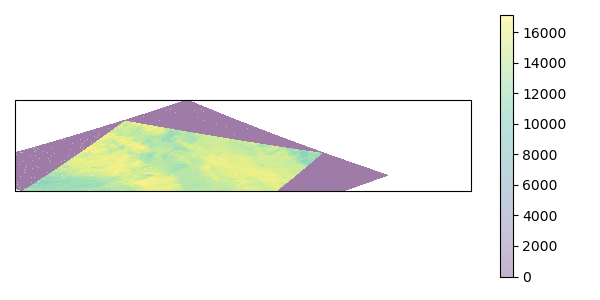

In [31]:
# plt.figure(figsize=(6, 3))
# ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_global()
# ax.pcolormesh(mod07.Longitude,mod07.Latitude,mod07.Water_Vapor,transform=ccrs.PlateCarree())
# cb = ax.pcolormesh(ls_scene.x,ls_scene.y,ls_scene.sel(band='lwir11'),alpha=0.3,transform=cartopy.crs.epsg(3031))
# ax.coastlines()
# ax.set_ylim([-70, -68])
# ax.set_xlim([-142,-132])
# plt.colorbar(cb)
# plt.tight_layout()

In [55]:
Lfile = '/home/jovyan/Landsat_SST_algorithm/Data/SST/Validation/LC08_L1GT_228108_20200123_20201016_02_T2_141253_Cel_calib.tif'
ls_scene = xr.open_dataset(Lfile)
ls_scene

<xarray.Dataset>
Dimensions:      (band: 1, x: 9081, y: 9101)
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 -2.495e+06 -2.495e+06 ... -2.223e+06 -2.223e+06
  * y            (y) float64 5.046e+05 5.046e+05 ... 2.316e+05 2.316e+05
    spatial_ref  int64 ...
Data variables:
    band_data    (band, y, x) float64 ...

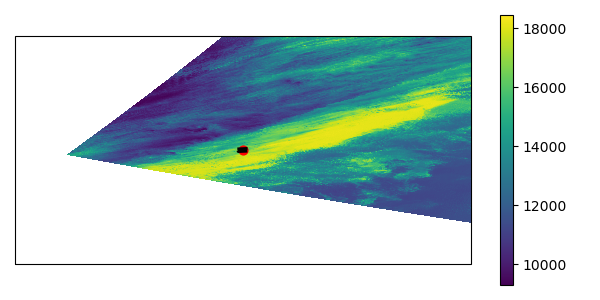

In [18]:
plt.figure(figsize=(6, 3))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
ax.set_ylim([ilat-1,ilat+1])
ax.set_xlim([ilon-2,ilon+2])
cb = ax.pcolormesh(ls_scene.x,ls_scene.y,ls_scene.sel(band=1).to_array().isel(variable=0),transform=cartopy.crs.epsg(3031))
plt.scatter([ilon],[ilat],c='r',s=40,transform=ccrs.PlateCarree())
plt.plot([polarx[0],polarx[0],polarx[1],polarx[1],polarx[0]],[polary[0],polary[1],polary[1],polary[0],polary[0]],lw=2,ls='--',color='k',transform=cartopy.crs.epsg(3031))
ax.coastlines()
plt.colorbar(cb)
plt.tight_layout()

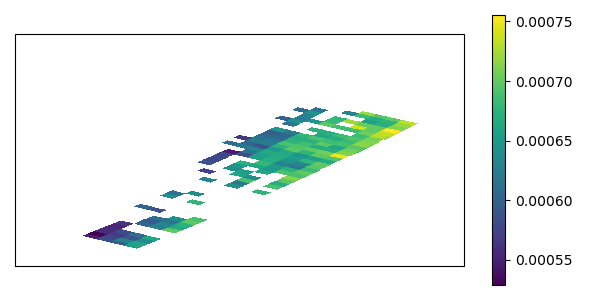

In [222]:
# plt.figure(figsize=(6, 3))
# ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_global()
# cb = ax.pcolormesh(WV_xr.x,WV_xr.y,WV_xr,transform=cartopy.crs.epsg(3031))
# ax.coastlines()
# ax.set_ylim([-72.6, -69.5])
# ax.set_xlim([-129,-123])
# plt.colorbar(cb)
# plt.tight_layout()

In [159]:
# Plot tiles of all scenes found
plot_search(gf,satellite,colnm)

:Overlay
   .Tiles.I    :Tiles   [x,y]
   .Polygons.I :Polygons   [Longitude,Latitude]   (landsat:wrs_path,landsat:wrs_row)

**Note the bands you would like to include are assigned by passing the bandNames parameter to landsat_to_xarray using the following codes:**

'coastal', 'blue', 'green', 'red', 'nir08', 'swir16', 'swir22', 'pan', 'cirrus', 'lwir11', 'lwir12', 'qa_pixel'

## Process calibrated Landsat scenes to create matchups

In [61]:
out_df = lsatpath / 'Landsat_validation_20230822_2023_01'
df1 = pd.read_pickle(out_df)
out_df = lsatpath / 'Landsat_validation_20230822_2022_01'
df2 = pd.read_pickle(out_df)
out_df = lsatpath / 'Landsat_validation_20230822_2021_01'
df3 = pd.read_pickle(out_df)
out_df = lsatpath / 'Landsat_validation_20230822_2018_01'
df4 = pd.read_pickle(out_df)

valids = pd.concat([df1,df2,df3,df4])
valids

,L8_filename,L8_SST,L8_std,Argo_id,Argo_SST
0,LC08_L1GT_009110_20230117_20230131_02_T2,NaN,NaN,2547953,-0.879000
1,LC08_L1GT_009109_20230117_20230131_02_T2,-1.367584,0.138925,2547953,-0.879000
0,LC08_L1GT_227108_20220105_20220114_02_T2,NaN,NaN,2236842,0.544000
1,LC08_L1GT_027112_20220128_20220204_02_T2,NaN,NaN,2237070,-1.589000
2,LC08_L1GT_008109_20220107_20220114_02_T2,NaN,NaN,2237071,-0.173000
0,LC08_L1GT_228108_20210109_20210307_02_T2,NaN,NaN,2270351,0.838000
1,LC08_L1GT_228109_20210109_20210307_02_T2,-1.370095,0.332311,2274965,0.312000
2,LC08_L1GT_001109_20210103_20210308_02_T2,NaN,NaN,2276425,-1.806000
3,LC08_L1GT_007109_20210113_20210308_02_T2,NaN,NaN,2278118,-1.473000
0,LC08_L1GT_228108_20180101_20201016_02_T2,-0.565709,0.065929,1790883,-0.049017


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


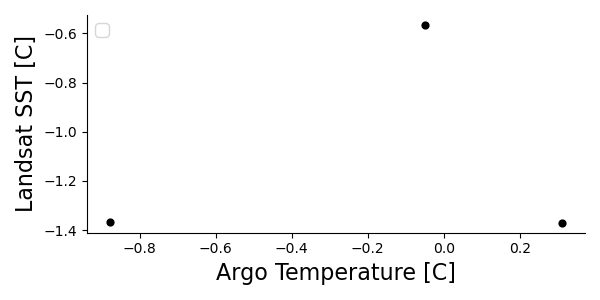

In [63]:
# Plot data points and RANSAC regression
fig, ax = plt.subplots(nrows=1, ncols=1, sharey=True,figsize=(6, 3))
xi = np.arange(-7.0,5.0,1.0)

data = valids

a1 = ax
a1.tick_params(labelsize=10)
a1.scatter(data['Argo_SST'],data['L8_SST'],color='k',linewidth=0,s=35,label='_no label_')
# a1.plot(xi,xi*lreg.coef_[0]+lreg.intercept_[0],color='r',linewidth=2,label='RANSAC regression')
# a1.scatter(xC,yLC,color='r',linewidth=0,s=35,label='_no label_')
# a1.plot(xi,xi*resultC.params.L8_SST+resultC.params.Intercept,color='k',linewidth=2,label='OLS regression')
# a1.text(-2.1,-2.85,f'y={np.around(resultC.params.L8_SST,2)}x+{np.around(resultC.params.Intercept,2)}   p={p_val}',fontsize=12)
a1.spines['top'].set_visible(False)
a1.spines['right'].set_visible(False)
# a1.set_ylim([-3,2.5])
# a1.set_xlim([-3,2.5])
a1.set_xlabel('Argo Temperature [C]',fontsize=16)
a1.set_ylabel('Landsat SST [C]',fontsize=16)
a1.legend(markerscale=1,fontsize=12,loc='upper left')

plt.tight_layout()
# plt.savefig('/Users/tsnow03/GoogleDrive/User/Docs/PhD_Project/Manuscripts/AmundsenCC_Manuscript/Figures/LMCalibration.jpg', format='jpg', dpi=1000)
plt.show()